### Introduction

L'objectif de ce TP est d'entraîner un modèle permettant de prédire la qualité du vin rouge en fonction de certaines de ses caractéristiques chimiques. 

Pour cela, on utilisera la version régression du K-nn, dont on choisira le nombre de voisins à l'aide d'une recherche sur grille réimplémentée dans le module **ma_selection_sur_grille.py** ci-joint. La métrique que l'on cherchera à optimiser sera l'erreur quadratique moyenne, mais on observera également le comportement du coefficient de détermination R².

Les données que l'on utilisera sont téléchargeables à l'emplacement suivant: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

- **Première partie** : Analyse et traitement préliminaire des données.
- **Deuxième partie** : Sélection d'un modèle de K-nn via la fonction de recherche sur grille ré-implémentée. 
- **Troisième partie** : Comparaison des performances du modèle à celles d’une baseline naïve en fonction de différentes heuristiques.


### I. Exploration et traitement préliminaire des données 

In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import des données
data = pd.read_csv('winequality-red.csv', sep=";")

# Exploration rapide
m = 'Le dataset contient {0} observations et {1} variables.\n'
print(m.format(data.shape[0], data.shape[1]))

m = 'Les variables présentes dans le dataset sont les suivantes:\n'
for feature in list(data.columns):
    m += '\t- ' + feature + '\n'
print(m)

# La variable que l'on cherche à prédire est la dernière : 'quality'
X = data[data.columns[:-1]]
y = data[data.columns[-1]]

Le dataset contient 1599 observations et 12 variables.

Les variables présentes dans le dataset sont les suivantes:
	- fixed acidity
	- volatile acidity
	- citric acid
	- residual sugar
	- chlorides
	- free sulfur dioxide
	- total sulfur dioxide
	- density
	- pH
	- sulphates
	- alcohol
	- quality



In [269]:
from sklearn import model_selection

# On divise les données du dataset en un jeu d'entraînement et un jeu de test
# 30% des données dans le jeu de test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,test_size=0.3)

In [270]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

### II. Choix du meilleur hyperparamètre pour un classifieur K-nn sur le train set
Dans cette partie:

- On choisira l'hyperparamètre du modèle K-nn, c'est-à-dire le nombre de voisins considérés pour effectuer la prédiction, via une fonction de recherche sur grille ré-implémentée. <br>NB : cette fonction a déjà été comparée à la recherche de scikit-learn model_selection.GridSearchCV dans un TP précédent, afin de montrer qu'elle en reproduisait correctement le fonctionnement.<br><br>

- Le choix final s'effectuera en optimisant l'erreur quadratique moyenne, mais on considérera aussi le coefficient de détermination R². On tentera de comparer les variations de ces deux grandeurs en fonction du nombre de voisins considérés. 

In [283]:
from ma_selection_sur_grille import Selection_Grille

In [284]:
from sklearn import neighbors, metrics

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]}
model = neighbors.KNeighborsRegressor()
score = 'mse'

# Appel de la nouvelle fonction de sélection sur grille
clf_mse = Selection_Grille(model,         # un classifieur kNN
                           param_grid,    # hyperparamètres à tester
                           cv=5,          # nombre de folds
                           score=score    # quantité à optimiser
                      )

clf_mse.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
m = "Meilleur hyperparamètre sur le jeu d'entraînement pour la métrique MSE:\n\t{0}\n"
print(m.format(clf_mse.best_params_))

# Afficher les performances correspondantes
print("Résultats de la recherche sur grille pour la métrique MSE:")
for mean, std, params in zip(clf_mse.cv_results_['mean_test_score'], # score moyen
                             clf_mse.cv_results_['std_test_score'],  # écart-type 
                             clf_mse.cv_results_['params']           # hyperparamètre
                            ):
    m = "\t{0} = {1:0.3f} (+/-{2:0.03f}) for {3}" 
    print(m.format(score,      # critère utilisé
                   mean,       # score moyen
                   std * 2,    # barre d'erreur
                   params      # hyperparamètre
                ))
    

Meilleur hyperparamètre sur le jeu d'entraînement pour la métrique MSE:
	{'n_neighbors': 17}

Résultats de la recherche sur grille pour la métrique MSE:
	mse = 0.520 (+/-0.183) for {'n_neighbors': 3}
	mse = 0.497 (+/-0.113) for {'n_neighbors': 5}
	mse = 0.472 (+/-0.105) for {'n_neighbors': 7}
	mse = 0.456 (+/-0.116) for {'n_neighbors': 9}
	mse = 0.452 (+/-0.114) for {'n_neighbors': 11}
	mse = 0.447 (+/-0.127) for {'n_neighbors': 13}
	mse = 0.442 (+/-0.129) for {'n_neighbors': 15}
	mse = 0.440 (+/-0.122) for {'n_neighbors': 17}
	mse = 0.441 (+/-0.120) for {'n_neighbors': 19}
	mse = 0.445 (+/-0.129) for {'n_neighbors': 21}
	mse = 0.446 (+/-0.132) for {'n_neighbors': 23}
	mse = 0.447 (+/-0.132) for {'n_neighbors': 25}
	mse = 0.446 (+/-0.130) for {'n_neighbors': 27}
	mse = 0.446 (+/-0.130) for {'n_neighbors': 29}


In [285]:
y_pred_mse = clf_mse.predict(X_test_std)
m = "Erreur quadratique moyenne obtenue sur le jeu de test en optimisant MSE : {0:0.3f}"
print(m.format(metrics.mean_squared_error(y_test, y_pred_mse)))

Erreur quadratique moyenne obtenue sur le jeu de test en optimisant MSE : 0.416


In [286]:
# On relance la recherche précédente avec la métrique 'coefficient de détermination'
score = 'R2'

# Appel de la nouvelle fonction de sélection sur grille
clf_R2 = Selection_Grille(model,         # un classifieur kNN
                          param_grid,    # hyperparamètres à tester
                          cv=5,          # nombre de folds
                          score=score    # quantité à optimiser
                         )

clf_R2.fit(X_train_std, y_train)

# On vérifie que les deux méthodes d'évaluation aboutissent au même choix:
m = "Meilleur hyperparamètre sur le jeu d'entraînement pour la métrique R²:\n\t{0}\n"
print(m.format(clf_R2.best_params_))

# Afficher les performances correspondantes
print("Résultats de la recherche sur grille pour la métrique R²:")
for mean, std, params in zip(clf_R2.cv_results_['mean_test_score'], # score moyen
                             clf_R2.cv_results_['std_test_score'],  # écart-type 
                             clf_R2.cv_results_['params']           # hyperparamètre
                            ):
    m = "\t{0} = {1:0.3f} (+/-{2:0.03f}) for {3}" 
    print(m.format(score,       # critère utilisé
                   mean,        # score moyen
                   std * 2,     # barre d'erreur
                   params       # hyperparamètre
                ))

Meilleur hyperparamètre sur le jeu d'entraînement pour la métrique R²:
	{'n_neighbors': 17}

Résultats de la recherche sur grille pour la métrique R²:
	R2 = 0.223 (+/-0.189) for {'n_neighbors': 3}
	R2 = 0.254 (+/-0.136) for {'n_neighbors': 5}
	R2 = 0.289 (+/-0.178) for {'n_neighbors': 7}
	R2 = 0.314 (+/-0.169) for {'n_neighbors': 9}
	R2 = 0.320 (+/-0.180) for {'n_neighbors': 11}
	R2 = 0.329 (+/-0.180) for {'n_neighbors': 13}
	R2 = 0.337 (+/-0.167) for {'n_neighbors': 15}
	R2 = 0.339 (+/-0.157) for {'n_neighbors': 17}
	R2 = 0.339 (+/-0.142) for {'n_neighbors': 19}
	R2 = 0.333 (+/-0.142) for {'n_neighbors': 21}
	R2 = 0.332 (+/-0.140) for {'n_neighbors': 23}
	R2 = 0.331 (+/-0.130) for {'n_neighbors': 25}
	R2 = 0.332 (+/-0.133) for {'n_neighbors': 27}
	R2 = 0.332 (+/-0.127) for {'n_neighbors': 29}


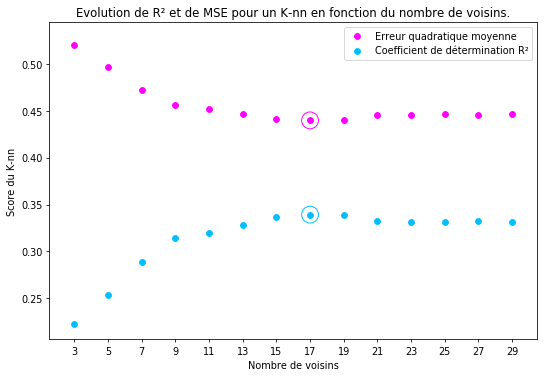

In [288]:
# On compare maintenant les variations de l'erreur quadratique moyenne
# à celles du coefficient de détermination en fonction du nombre
# de voisins considérés.

# On trace pour cela un graphe des deux grandeurs, MSE en rouge et R² en bleu. 
# On entoure sur le graphe la valeur optimale sélectionnée par la recherche sur grille. 
# - Pour l'erreur quadratique moyenne, il s'agira de la plus petite.
# - Pour R², il s'agira de la plus grande.
# On vérifie que ces valeurs sont atteintes pour le même nombre de voisins.

def plot_scores_classifier(classifieur, couleur, label):
    """
    Fonction utilitaire permettant de tracer les valeurs prises 
    par une métrique (MSE ou R²) en fonction du nombre de voisins.
    """
    nb_voisins = [str(t['n_neighbors']) for t in classifieur.cv_results_['params'] ]
    scores = classifieur.cv_results_['mean_test_score']
    plt.scatter(nb_voisins, scores, color=couleur, label=label)

    # On entoure la meilleure valeur
    nb_optimal = classifieur.best_params_['n_neighbors']
    
    plt.scatter([str(nb_optimal)], 
                [scores[int((nb_optimal-3)/2)]], 
                edgecolors=couleur,
                facecolors='none',
                s=300 )

def plot_graph():
    plt.figure(figsize=(9, 6), dpi=70)
    plot_scores_classifier(clf_mse, 'magenta', 'Erreur quadratique moyenne')
    plot_scores_classifier(clf_R2, 'deepskyblue', 'Coefficient de détermination R²')
    plt.xlabel('Nombre de voisins')
    plt.ylabel('Score du K-nn')
    title = 'Evolution de R² et de MSE pour un K-nn en fonction du nombre de voisins.'
    plt.title(title)
    plt.legend()

plot_graph()

L'optimisation du modèle K-nn peut donc se faire indifféremment en maximisant le coefficient de détermination *R²* ou en minimisant l'erreur quadratique moyenne *MSE*. Ce n'est pas surprenant étant de donné que ces deux grandeurs sont reliées par la formule suivante: <br>
\begin{equation*}
R² \approx 1 - \frac{mse}{\sigma_y^2} 
\end{equation*}


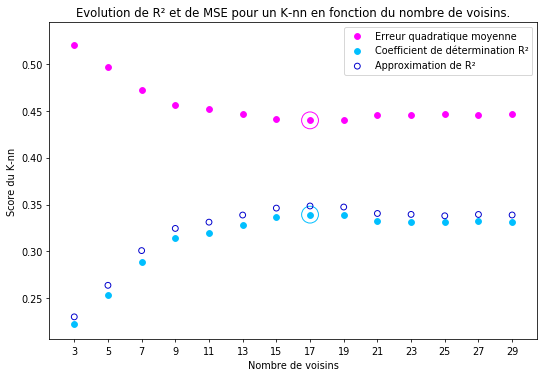

In [289]:
# Montrons que la formule ci-dessus est vérifiée dans notre cas.
mse = clf_mse.cv_results_['mean_test_score']
R2 = clf_R2.cv_results_['mean_test_score']
n = len(mse)

std_deviation = np.std(y_train)

# On calcule pour chaque nombre de voisin le membre de droite de la formule
formule = [ (1. - (mse[t]/std_deviation**2)) for t in range(n)]

# On affiche le membre de droite de la formule en bleu foncé sur le graphe précédent
plot_graph()

nb_voisins = [str(t['n_neighbors']) for t in clf_mse.cv_results_['params']]

plt.scatter(nb_voisins, formule, 
            edgecolors='mediumblue', 
            facecolors='none', 
            label='Approximation de R²')

l = plt.legend()

### III. Comparaison des performances à celles de baselines naïves

On compare notre modèle aux approches naïves suivantes:
- Prédiction aléatoire dans l'espace des valeurs de y_train
- Prédiction constante égale à la moyenne des valeurs de y_train

On compare les modèles via les heuristiques suivantes:
- **MSE**:   Erreur quadratique moyenne.
- **RMSE**:  Racine carrée de l'erreur quadratique moyenne.
- **RSS**:   Somme des carrés des résidus.
- **RSE**:   Erreur carrée relative: RSE = RSS/SST, où SST est la somme des carrés des distances à la moyenne.
- **-R²**: Opposé du coefficient de détermination. On multiplie R² par -1 afin qu'il soit optimisable par minimisation comme les autres métriques du dictionnaire.

In [281]:
model_comparison = dict()
mean_train = np.mean(y_train)
prediction_main = [mean_train for t in range(len(y_test))]
nt = len(y_test)
    
def add_model_scores(model, prediction):
    """
    Ajouter un modèle au dictionnaire model_comparison.
    """    
    # On calcule les grandeurs nécessaires pour obtenir l'erreur carrée relative (RSE)
    rss = nt * metrics.mean_squared_error(y_test, prediction)
    sst = nt * metrics.mean_squared_error(y_test, prediction_main)
    rse =  rss / sst    
    
    model_comparison[model] = {'mse': metrics.mean_squared_error(y_test, prediction),
                               'rmse': np.sqrt(metrics.mean_squared_error(y_test, prediction)),
                               'rss': rss,
                               'rse': rse,
                               '-r2': -metrics.r2_score(y_test, prediction)}
    
y_pred_random = np.random.randint(np.min(y_train), np.max(y_train), y_test.shape)

add_model_scores('random', y_pred_random)
add_model_scores('constant', prediction_main)
add_model_scores('k-nn', y_pred_mse)

df = pd.DataFrame(model_comparison)
df['best'] = df.min(axis=1)

df.style

,random,constant,k-nn,best
-r2,4.31721,0.0052192,-0.300851,-0.300851
mse,3.16042,0.597477,0.415557,0.415557
rmse,1.77776,0.772966,0.644637,0.644637
rse,5.2896,1,0.695519,0.695519
rss,1517,286.789,199.467,199.467


### Conclusion
On voit dans la grille ci-dessus que, pour toutes les heuristiques considérées, le modèle k-nn optimisé grâce à la recherche sur grille est meilleur que les deux modèles naïfs présentés. 